In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import pylab as pl
import os
from IPython import display
from subprocess import call
from datetime import datetime
import subprocess
import sys
sys.path.append('/Users/vsriniv/Documents/Research/GitHub/PatchSim')
import patchsim as sim
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'geopandas'

In [99]:
# od_matrix = pd.read_csv('../data/pop_travel/OD_Matrix.csv')
# od_matrix['Grav'] = (od_matrix.Origin_Pop*od_matrix.Destination_Pop)/(od_matrix.Travel_Time**2)
# do_matrix = od_matrix.copy(deep=True)
# do_matrix.columns = ['Destination','Destination_Pop','Origin','Origin_Pop','Travel_Time','Grav']
# do_matrix = do_matrix[od_matrix.columns]
# od_matrix = od_matrix.append(do_matrix)
# od_matrix = od_matrix.assign(norm_flow=od_matrix.Grav.div(od_matrix.groupby(['Origin']).Grav.transform('sum')))
# od_matrix = od_matrix[['Origin','Destination','norm_flow']]

# hz = od_matrix.Origin.unique()
# non_commute=0.7
# df = pd.DataFrame({'Origin':hz,'Destination':hz,'norm_flow':np.repeat(non_commute,len(hz))})
# od_matrix.norm_flow = od_matrix.norm_flow*(1-non_commute)
# od_matrix = od_matrix.append(df[['Origin','Destination','norm_flow']])
# od_matrix['temp'] = 0
# od_matrix[['Origin','Destination','temp','norm_flow']].to_csv('../data/patchsim/grav_drc.csv',sep=' ',index=None,header=None)

In [100]:
pop_df = pd.read_csv('../data/pop_travel/District_Data.csv')
pop_df['District_Name']=pop_df.District_Name.apply(lambda x: x.decode('unicode_escape').encode('ascii','ignore').replace('?',''))
#pop_df[['District_ID','Population']].to_csv('../data/patchsim/pop_drc.csv',sep=' ',index=None,header=None)

In [101]:
cfgs = sim.read_config('../data/patchsim/cfg.txt')
sim.run_disease_simulation(cfgs,write_epi=True)

In [102]:
out_df = pd.read_csv('../outputs/sample.out',delimiter=' ',header=None,index_col=0)
out_df = out_df.groupby((out_df.columns - 1)// 7, axis=1).sum()
wk_range = out_df.columns[:-4]
out_df = out_df[wk_range] ## To remove last week which is partial
out_df.index.name='District_ID'
out_df.reset_index(inplace=True)
out_df = out_df.merge(pop_df[['District_ID','District_Name']],on='District_ID')

In [103]:
gdf = gpd.read_file('../data/shapefile/DRC-healthzones/zone_stc_puc.shp')
gdf['District_Name'] = gdf.apply(lambda x: x['Nom_DS_PUC']+':'+x['Nom_ZS_PUC'],axis=1)
gdf['District_Name'] = gdf.District_Name.apply(lambda x: x.encode('ascii','ignore'))
gdf = gdf[['District_Name','geometry']]
gdf = gdf.merge(out_df,on=['District_Name'])

In [104]:
out_df[wk_range].sum().cumsum()

0     14
1     21
2     28
3     36
4     57
5     94
6    155
7    264
8    483
dtype: int64

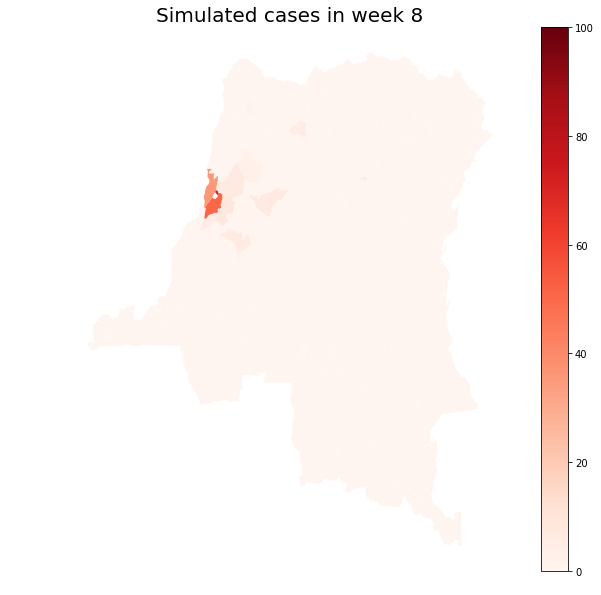

In [110]:
count=0
for wk in wk_range:
    f = plt.figure(figsize=(10,10))
    ax = plt.gca()
    plt.axis('off')
    plt.title('Simulated cases in week {}'.format(wk),fontsize=20)
    gdf.plot(ax=ax,column=wk,cmap='Reds',vmin=0,vmax=100,legend=True)
    display.clear_output(wait=True)
    display.display(pl.gcf())    
    plt.savefig('../plots/{:02d}.png'.format(count),bbox_inches='tight')
    count+=1
    plt.close()
call("convert -delay 200 -loop 1 ../plots/*.png ../plots/sim_anim.gif".split(' '))
[os.remove('../plots/'+x) for x in os.listdir('../plots') if '.png' in x];

In [106]:
evd_df = pd.read_csv('../data/ebola_drc/drc/data.csv').fillna(0)
evd_df = evd_df[1:]
evd_df = evd_df[evd_df.health_zone!='Ntondo'] ## Currently no cases
evd_df['Date'] = evd_df.report_date.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
evd_df['all_cases'] = evd_df.confirmed_cases + evd_df.probable_cases + evd_df.suspect_cases

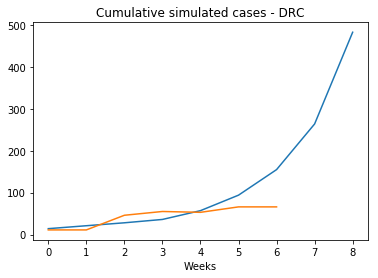

In [107]:
ax = out_df[wk_range].sum().cumsum().plot()
gt = np.pad(evd_df.groupby('Date')['all_cases'].sum().values[::7],(1,), 'edge')
ax.plot(gt)
plt.title('Cumulative simulated cases - DRC')
plt.xlabel('Weeks')
plt.savefig('../plots/sim_epicurve.jpg',dpi=100)

In [108]:
out_df[wk_range].sum().cumsum()

0     14
1     21
2     28
3     36
4     57
5     94
6    155
7    264
8    483
dtype: int64

In [109]:
out_df['Total'] = out_df[wk_range].sum(axis=1)
temp_df = out_df.sort_values('Total',ascending=False)[['District_Name','Total']]
temp_df['risk_index'] = temp_df.Total/temp_df.Total.sum()
print temp_df[['District_Name','risk_index']].head(10).to_string(index=False)
temp_df[['District_Name','risk_index']].head(10).to_html('../plots/table.html',index=False)

District_Name  risk_index
           Equateur:Bikoro    0.376812
          Mbandaka:Wangata    0.322981
  Equateur:Lilanga Bobangi    0.151139
          Equateur:Ingende    0.026915
            Equateur:Iboko    0.026915
            Tshuapa:Boende    0.018634
          Equateur:Bolomba    0.014493
Kisangani:Makiso-Kisangani    0.012422
           Mai-Ndombe:Kiri    0.012422
           Equateur:Ntondo    0.010352


In [95]:
temp_df[['District_Name','risk_index']].head(3)

,District_Name,risk_index
497,Equateur:Bikoro,0.524823
250,Mbandaka:Wangata,0.347518
505,Equateur:Lilanga Bobangi,0.127660
